# Final notebook

#### RWS Group 3

- Janine Timmerman - 4831578
- Honghao Zhao - 5735289
- 
- 
- 

***Important information***

This notebook is the final notebook of RWS group 3. This notebook will take you through our process and shows the final results and conclusions. To keep this notebook clear and not too cluttered, not all the details will be presented in this notebook. Each section will refer to other notebooks if needed to show the full code and process. 

This notebook and all other notebooks important for understanding the process will be available as a .ipynb file which can be run (altough it might take a lot of time), and a html file for easy viewing. All the html version of the notebooks can be found in the folder: **html_notebooks**.

The backlog diary can be found in github in the wiki.

The dashboard can be accessed with the following link: https://rws-group3-48o79awm3zv6cbmgpeaj2d.streamlit.app/ 
(Loading the dashboard should not take more than 1 or 2 minutes. We've noticed it doesn't work (quickly) on all computers. Otherwise you could try a different browser/ pc if possible or watch the demo we provide: ***LINK FOR VIDEO SHOWCASING THE DASHBOARD***)

## Table of contents

* 1 Introduction
* 2 Importing modules
* 3 Analysis of incident data

    * 3.1 Filtering of the data
    * 3.2 Analysis of incidents
    * 3.3 Splitting training and validation data

* 4 Travel times

    * 4.1 Speed data on road sections
    * 4.2 NetworkX graph creation
    * 4.3 Travel time between nodes


* 5 Algorithms for inspector locations

    * 5.1 Objective functions
    * 5.2 K-means clustering by distance
    * 5.3 K-means clustering by travel time
    * 5.4 Simulated Annealing
    * 5.5 Frequency-based
    
* 6 Validation
* 7 Results and conclusions
* 8 Discussion

## 1. Introduction

Each day many incidents happen on the road network of the Netherlands. To minimize the consequences on other traffic, road inspectors are send to the locations of the incidents. To ensure good and safe traffic flow, it is important that the road inspectors reach the locations as fast as possible. For this the road inspectors need to be stationed at efficient places so all incidents locations can be reached as far as possible. Currently, the average travel time of a road inspector to an incident is 18 minutes. The goal of this assignment is to find locations to get a travel time lower than 18 minutes. 

This gives the following research question:

***What are the optimum locations for road inspectors to reach incidents as fast as possible?***

To help answer the question, there are several subquestions

* What are the best optimisation methods to locate the road inspectors to reach the incidents?
* What kind of different scenarios could be classified? (e.g. peak hour situation)
* How many inspectors should be introduced to the network in total to ensure that each incident has at least one inspector?

The remainder of this notebook will show the locations of inspectors we found and the process that brought us there. First, the data of the incidents is filtered and analysed. After that, data is collected about the speed and intensities of the road network, which is used ot determine the speed and travel times on each road section. After that the different algorithms are presented. The results of these algorithms are then validated and finally, the result and conclusions are shown. 

## 2. Importing modules

In this project, many different python modules and libraries were used to make our code more efficient and to showcase the visualizations. There modules are imported in this section.

If it is not possible to run the following noteblock (and you want to): you can install the missing modules using

        pip install "NAME"

In [17]:
# Calculations
import numpy as np
import numpy_indexed as npi
import math

import pandas as pd
import geopandas as gpd

from scipy import spatial

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import namedtuple

import networkx as nx
from geopy.distance import geodesic


# Visualization
import folium 
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

import branca.colormap as cm
from distinctipy import distinctipy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

import json

# Others
import pickle

In [ ]:
# Functions for converting coordinates

def DutchRDtoWGS84(rdX, rdY):
    """ Convert DutchRD to WGS84
    """
    RD_MINIMUM_X = 11000
    RD_MAXIMUM_X = 280000
    RD_MINIMUM_Y = 300000
    RD_MAXIMUM_Y = 630000
    if (rdX < RD_MINIMUM_X or rdX > RD_MAXIMUM_X
        or rdY < RD_MINIMUM_Y or rdY > RD_MAXIMUM_Y):
        resultNorth = -1
        resultEast = -1
        return resultNorth, resultEast
    # else
    dX = (rdX - 155000.0) / 100000.0
    dY = (rdY - 463000.0) / 100000.0
    k = [[3600 * 52.15517440, 3235.65389, -0.24750, -0.06550, 0.0],
        [-0.00738   ,   -0.00012,  0.0    ,  0.0    , 0.0],
        [-32.58297   ,   -0.84978, -0.01709, -0.00039, 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00530   ,    0.00033,  0.0    ,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    l = [[3600 * 5.38720621,    0.01199,  0.00022,  0.0    , 0.0],
        [5260.52916   ,  105.94684,  2.45656,  0.05594, 0.00128],
        [-0.00022   ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [-0.81885   ,   -0.05607, -0.00256,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00026   ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    resultNorth = 0
    resultEast = 0
    powX = 1

    for p in range(6):
        powY = 1
        for q in range(5):
            resultNorth = resultNorth + k[p][q] * powX * powY / 3600.0
            resultEast = resultEast + l[p][q] * powX * powY / 3600.0
            powY = powY * dY
        powX = powX * dX
    return resultNorth, resultEast

def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

def calc_distance(line_wkt):
    line = ogr.CreateGeometryFromWkt(line_wkt)
    points = line.GetPoints()
    d = 0
    for p0, p1 in zip(points, points[1:]):
        d = d + geodesic(p0, p1).m
    return d

## 3. Analysis of incident data

This section will filter and analyse the incident data. After that the data is split for training the algorithms and validating the algorithms.

For the full filtering and data analysis see ***NAME NOTEBOOK***

### 3.1 Filtering of the data

Define a function that can:
- (1) Delete the incidents which are not occured on the high ways 
- (2) Delete the incidents which the values for road number is missing 
- (3) Change name of all roads 'hrb'
- (4) Delete the incidents that are out of the border of the Netherlands 

In [18]:
# Define a function to filter data
def data_filter(data_input):
    data_input = incidents.dropna()
    data_input.loc[:,'road_number'] = data_input['road_number'].replace({'A12 hrb':'A12', 'A16 hrb':'A16', 'A2 hrb':'A2'})
    new_data = data_input[data_input['road_number'].str.startswith('A')]
    new_data.drop(new_data.loc[new_data['index'] == 183130].index, inplace=True)
    
    return new_data

# Read raw data from a csv file
incidents = pd.read_csv('Dashboard_data\incidents_data', sep=';')
incidents.columns = ['index', 'id', 'type', 'start_time','end_time', 'road_number','longitude','latitude']
incidents['start_time'] = pd.to_datetime(incidents['start_time'])
incidents['end_time'] = pd.to_datetime(incidents['end_time'])
incidents.head()

# Dataframe of filtered data
incidents_df = data_filter(incidents)

### 3.2 Analysis of incidents

Some explanation text

In [3]:
# Code

### 3.3 Splitting training and validation data

Some explanation text

In [4]:
# Code

## 4. Travel times

Each algorithm will need to calculate the travel times between inspectors and incidents to find the optimal locations of the road inspectors. All the tools needed to calculate these travel times are given in this section.

### 4.1 Speed data on road sections

First the speed on each road section of the network is determined. For the full calcutions please take a look at the notebook **speed_network_data.ipynb** or **NAME HTML VERSION**. This section will only show the results.

First there is the following dataframe. It has been obtained by combining the given shapefiles, open source wkd ("Wegkenmerkendatabase") data about the maximum speed and INWEVA ("INtensiteit WEgVAkken") data which gives traffic intensities on road sections. There was some missing data, which has been filled with data from adjacent road sections.

In [5]:
road_section_data = pd.read_csv('speed_data', sep=';')
road_section_data.head()

,Road_section_id,Road_number,Section_length_(m),geometry,Max_speed,coords,Min_travel_time_[s],No_of_lanes,Morning_peak_[veh/h],Evening_peak_[veh/h],Average_peak_[veh/h],Peak_speed_km/h,Peak_travel_time_[s]
0,235252052,A15,225.0,"LINESTRING (117613.756 426301.388, 117622.09 4...",130.0,"[(117613.756, 426301.388), (117622.09, 426302....",6.2,1.0,288.0,270.0,279.0,107.7,7.5
1,463451006,A37,209.0,"LINESTRING (231708.389 525975.794, 231713.477 ...",130.0,"[(231708.389, 525975.794), (231713.477, 525976...",5.8,1.0,242.0,504.0,373.0,107.2,7.0
2,398527014,A7,125.0,"LINESTRING (199413.84100000001 563825.915, 199...",130.0,"[(199413.84100000001, 563825.915), (199429.067...",3.5,1.0,88.0,132.0,110.0,108.6,4.1
3,181193022,A17,350.0,"LINESTRING (90581.131 396850.172, 90598.799 39...",130.0,"[(90581.131, 396850.172), (90598.799, 396873.0...",9.7,1.0,134.0,318.0,226.0,108.0,11.7
4,205343018,A44,149.0,"LINESTRING (102810.117 471704.421, 102817 4717...",120.0,"[(102810.117, 471704.421), (102817.0, 471705.0...",4.5,1.0,216.0,312.0,264.0,107.1,5.0


The travel times on each road section have been determined for optimal conditions, which assumed that the road inspector is driving at the maximum speed (in 2019) and for peak hour conditions. The peak hour conditions were estimated using a data-driven function using data like the intensity on the road, time of the day, no. of lanes, etc. (See the speed_network_data notebook for all details)

### 4.2 NetworkX graph creation

As stated above, there was some missing data about e.g. the maximum speed on the road sections. This data was filled by looking at the maximum speed of adjacent road sections. This was done by creating a directed NetworkX graph. 

Beneath, you see the code that was used to create the graph. The start and end point of each edge was added as a node to the network. The road section was then added as an edge between the two nodes. Several attributes were added to the edges to keep track of the properties of the road section.

    G = nx.DiGraph()
    nx.set_edge_attributes(G, 0, 'Max_speed')
    nx.set_edge_attributes(G, 0, 'Road_number')
    nx.set_edge_attributes(G, 0, 'Road_section_id')

    for i in range(len(merged_network)):

        # Get the first and last node from each road section
        start = merged_network.geometry[i].coords[0]
        end = merged_network.geometry[i].coords[-1]

        # Add the nodes and edges to the graph
        G.add_node(start)
        G.add_node(end)

        G.add_edge(start, end, geometry=merged_network.geometry[i])

        # Add different attributes from the dataframe to the graph
        G.edges[(start, end)]['Max_speed'] = merged_network.Max_speed[i]
        G.edges[(start, end)]['Road_number'] = merged_network.Road_number[i]
        G.edges[(start, end)]['Road_section_id'] = merged_network.Road_section_id[i]

Because of NetworkX functions, it was easy to get adjecent edges tp use for filling in missing data. Later on, more attributes were added to the network as more was calculated.

In [6]:
# Load networkX graph
G = pickle.load(open('NetworkX_graph.pickle', 'rb'))

# Show edge attributes of random edge
G.edges[list(G.edges)[0]]

{'geometry': <LINESTRING (117613.756 426301.388, 117622.09 426302.275, 117634.941 426306....>,
 'Max_speed': 130.0,
 'Road_number': 'A15',
 'Road_section_id': 235252052,
 'Min_travel_time_[s]': 6.2,
 'Peak_travel_time_[s]': 7.5,
 'Peak_speed': 107.7}

As you can see, the graph contains speeds for optimal and peak hour conditions, road number, road section id and the travel times.

However, when trying to find the path between shortest nodes, it was quickly concluded that this graph is not yet strongly connected. In other words, it was not possible to find a path between each two nodes.

In [7]:
nx.is_strongly_connected(G)

False

The next step was to make the graph fully connected, so it is possible to calculate the travel time between all nodes. The full process of connecting all nodes can be found in the following notebook: **connect_networkX_graph.ipynb** or **HTML VERSION**.

To connect the full network, two different algorithms were used.

First, there was looped over each node in graph G to check if the node missed an incoming or outgoing node. If one of those were missing, the algorithms would loop over the nearest nodes and check if it complied to several constraints. If so, the nodes were connected. Using this method around 1800 edges were added to the network and all nodes had at least an incoming and an outgoing edge. (So it is possible to reach and leave the node).

After that, the network was still not strongly connected and a second algorithm was used. There were still over 400 strongly connected components (instead of 1). The second algorithm looped over all strongly connected components and would connect each component to the nearest component. This algorithm used less constraints and the added edges might be less accurate.

Still, after the second algorithm, the whole network was strongly connected.

In [8]:
# Load networkX graph
G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

# Check if new network is strongly connected
nx.is_strongly_connected(G)

True

Now, there only needs to be checked if edges that were added to the network seem realistic.

In [9]:
# Get info about when the edge was added (or if it already existed)
new_edge_val = np.array(list(nx.get_edge_attributes(G, 'New_edge').values()))
new_edge_key = np.array(list(nx.get_edge_attributes(G, 'New_edge').keys()))

In [13]:
edges_sorted = []

for i in range(3):
    edges_sorted.append(new_edge_key[new_edge_val == i])

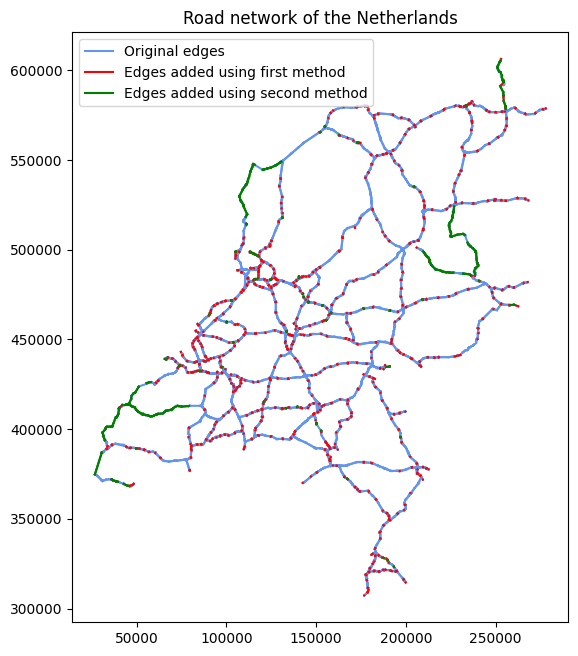

In [14]:
# Create figure
fig, ax = plt.subplots()

ax.set_title('Road network of the Netherlands')

# Give axis equal scale
fig.set_figheight(9)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Define colors and labels
colors = ['cornflowerblue', 'red', 'green']
labels = ['Original edges', 'Edges added using first method',
          'Edges added using second method']

# Plot the different colored edges in the road network
for i in range(3):
    ax.plot([],[], color=colors[i], label=labels[i])

    for j in range(len(edges_sorted[i])):
        ax.plot(edges_sorted[i][j,:,0], 
                edges_sorted[i][j,:,1], color=colors[i])



plt.legend(loc='upper left');

As you can see, all the edges added in the first iteration seem to connect small stretches between nodes.'

The green edges are larger, especially around several roads in Zeeland and Drenthe. This is due to the fact these are more regional roads and were given in the shapefile as a single lane, instead of several lanes as was done for the highways. This means according to the networkX graph, the road could only be driven in one direction and that had to be fixed.

### 4.3 Travel time between nodes

Now the network graph is finished, a function must be defined to calculate travel times. This function is used in all the algorithms to calculate the travel times. For the full notebook of this function see **df.ipynb** or **HTML VERSION**. This notebook also shows several visualizations of shortest paths between nodes and some visualizations about the areas an inspector serves.

In [19]:
# travel_time function
def travel_time_func(point1, point2, time='min'):
    """This function uses the information given in network X to return the travel time between two points.
        point1 and point2 should be tuples with the coordinates in longitude, latitude.
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""

    # Determine which travel times to use
    if time == 'peak':
        time_string = 'Peak_travel_time_[s]'
    else:
        time_string = 'Min_travel_time_[s]'

    # Change points to Dutch system
    p1_x, p1_y = WGS84toDutchRD(point1[0], point1[1]) # inspector
    p2_x, p2_y = WGS84toDutchRD(point2[0], point2[1]) # incident

    # Create numpy matrix from nodes
    A = np.array(list(G.nodes()))

    # Get node closest to each point
    dist_node1, index_node1 = spatial.KDTree(A).query([p1_x, p1_y])
    node1 = (A[index_node1][0], A[index_node1][1])

    dist_node2, index_node2 = spatial.KDTree(A).query([p2_x, p2_y])
    node2 = (A[index_node2][0], A[index_node2][1])

    # Get shortest path between nodes
    route = nx.shortest_path(G, node1, node2, time_string)
    travel_time = nx.shortest_path_length(G, node1, node2, time_string)

    return route, travel_time

This function needs as input the WGS84 coordinates of the inspector (origin) and the incident (destination). It then searches for the node closest to the inspector and the node closest to the incident. After that, the shortest path between those 2 nodes is calculated based, using the travel time in optimal conditions, or if you prefer, the travel time using peak hour conditions. 

Because the distances between 2 nodes are often short (most of the time it takes only a few seconds to travel between two adjacent nodes), the distance between the actual locations and the nodes is neglected. In the aforementioned notebook, the travel times between the node and each incident was calculated (assuming a speed of 120 km/h and eucledian distance), and on average it took 9.1 seconds, while the median was 3.4 seconds. This is not much time when looking at an average travel time of 18 minutes.
 
(There are several larger outliers however, where the distance between a node and incident are up to 6 minutes. This makes this method less accurate, because the actual travel time between the incident and the inspector could be 6 minutes longer or shorter. But because the average travel time is still many times lower, those outliers will be neglected.)

## 5. Algorithms for inspector locations

In this section the 4 different algorithms are presented.

### 5.1 Objective functions

***Add explanations about which objective function is used, or some other like that. Anyway, make it clear how the results of the algorithms can be compared.***

The objective function is to compare the number of road inspectors within a time limit, given a fixed mean trvael time, the less the road inspectors, the better the method is.

### 5.2 K-means clustering by distance

The algorithm of K-means clustering by distance uses the incidents data and the network information as the input. 

The following steps explain how this method work:

1 ) The algorithm uses the Euler distance to cluster all the incidents. The number of road inspectors are straightly linked to the number of clusters, one cluster has one road inspector. The initial value of k is define as 120 in this algorithm.

2 ) With the obtained cluster centers, find the nearest node of the road network. The NetworkX and a method of kd-tree is used to find the nearest network node for each cluster center. The found nodes are considered as the locations of the road inspectors.

3 ) Calculate the mean travel time of this scenario, check if the mean travel time is within the time limit. If so, minus one to the number of clusters (a.k.a the number of road inspectors).

4 ) Repeat step 1 to step 3 until the mean travel time exceeds the time limit. Then the scenario before the scenario in which the iteration stop is considered as the optimal scenario.

The result of this algorithm is saved to a .html file named "min_inspector_map.html", a single run of this algorithm could take around 5 hours. For further studying purpose, the travel time in peak hours are also used to find the optimal locations of road inspectors, the result is also saved to a .html file. The result of locations of road inspectors during peak hours can be refered in 'peak_inspector_map'.

In [20]:
# Create a list of converted coordinates
converted_coordinates = [DutchRDtoWGS84(rd_x, rd_y) for (rd_x, rd_y) in list(G.nodes)]

# Create a Pandas DataFrame from the converted coordinates
node_df = pd.DataFrame(converted_coordinates, columns=['Latitude', 'Longitude'])

# Display the DataFrame
node_df

# Define a data structure to store kd-tree nodes
KdNode = namedtuple("KdNode", "point left right")

# Build k-d tree
def kdtree(point_list, depth=0):

    if not point_list:
        return None

    k = 2  # 2-dimensional space
    axis = depth % k

    point_list.sort(key=lambda x: x[axis])
    median = len(point_list) // 2

    return KdNode(
        point=point_list[median],
        left=kdtree(point_list[:median], depth + 1),
        right=kdtree(point_list[median + 1 :], depth + 1),
    )


# Find the closest point
def closest_node(root, target, depth=0, best=None):
    if root is None:
        return best

    k = 2  # 2-dimensional space
    axis = depth % k

    next_best = None
    next_branch = None

    if best is None or (
        point_distance(root.point, target) < point_distance(best, target)
    ):
        next_best = root.point
    else:
        next_best = best

    if target[axis] < root.point[axis]:
        next_branch = root.left
    else:
        next_branch = root.right

    return closest_node(next_branch, target, depth + 1, next_best)


# Calculate the distance between points
def point_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


# Extract points from dataframe
points = [(row[0], row[1]) for index, row in node_df.iterrows()]
tree = kdtree(points)


def clustering_opt(k_value, data, target_travel_time):
    # Create a K-Means clustering model
    kmeans = KMeans(n_clusters=k_value)

    # Fit the model to the latitude and longitude data
    locations = data[["latitude", "longitude"]].values
    kmeans.fit(locations)

    # Assign cluster labels to data points
    data["cluster"] = kmeans.labels_ + 1

    m = folium.Map(
        location=[np.mean(locations[:, 0]), np.mean(locations[:, 1])],
        zoom_start=8,
        zoom_control=False,
    )

    # Create a MarkerCluster layer for clustered data
    marker_cluster = MarkerCluster().add_to(m)

    # Create a dictionary to keep track of the event count in each cluster
    cluster_event_count = {}

    # Create an array to store node coordinates for each cluster
    cluster_coords = []

    # Initiate the longest travel time
    longest_travel_time = -1  # second

    # Initiate the total travel time
    total_travel_time = -1  # second

    # Initiate the point count
    point_count = 0

    # Add markers for clustering
    for cluster_label in range(1, k_value + 1):
        cluster_data = data[data["cluster"] == cluster_label]
        cluster_count = len(cluster_data)
        cluster_event_count[cluster_label] = cluster_count
        cluster_coords.append(cluster_data)

        for _, row in cluster_data.iterrows():
            popup_text = f"Cluster: {row['cluster']}<br>Type: {row['type']}<br>Index: {row['index']}"
            folium.Marker(
                [row["latitude"], row["longitude"]], icon=None, popup=popup_text
            ).add_to(marker_cluster)

    cluster_centers = kmeans.cluster_centers_
    ins_loc = [closest_node(tree, coord) for coord in cluster_centers]

    for i, center in enumerate(ins_loc):
        cluster_label = i + 1
        center_popup_text = f"Cluster_No.{i + 1}<br>Event_Count:{cluster_event_count[cluster_label]} \
            <br>Coordinate:{[format(center[0], '3f'), format(center[1], '.3f')]}"

        # Use ClickForMarker to display the event count when clicking the cluster center
        folium.ClickForMarker(popup=center_popup_text).add_to(m)

        folium.Marker(
            [center[0], center[1]],
            icon=folium.Icon(color="red"),
            popup=center_popup_text,
        ).add_to(m)

    # Initialize a list to store time-related information
    time_data = []

    # Calculate and update the longest travel time in each cluster
    for i, center in enumerate(ins_loc):
        cluster_label = i + 1
        cluster_data = data[data["cluster"] == cluster_label]
        point1 = (ins_loc[i][1], ins_loc[i][0])

        for index, row in cluster_data.iterrows():
            point2 = (row["longitude"], row["latitude"])
            r, time_this = travel_time_func(point1, point2, time='min')
            total_travel_time += time_this

            if time_this > target_travel_time:
                point_count += 1

            # Store time-related information in the time_data list
            time_data.append(
                [
                    row["index"],
                    row["id"],
                    row["type"],
                    row["longitude"],
                    row["latitude"],
                    cluster_label,
                    time_this,
                ]
            )

    # Create a Pandas DataFrame to store time-related information
    time_df = pd.DataFrame(
        time_data,
        columns=[
            "index",
            "id",
            "type",
            "longitude",
            "latitude",
            "cluster",
            "time_this",
        ],
    )

    # Calculat the mean travel time
    incident_count = data.shape[0]
    mean_travel_time = total_travel_time / incident_count

    # Print the longest travel time of the scenario with specific number of inspectors
    print(f"The mean travel time is {mean_travel_time} seconds!")

    return m, ins_loc, mean_travel_time, point_count, time_df


def find_optimal(initial_k_value, target_travel_time):
    # The unit of travel time is second
    k_value = initial_k_value

    # Initialize the travel time
    flag = True

    # Iterate to find the optimal number
    while True:
        if flag == False:
            # Keep a record for the previous optimised results
            opt_clustered_map = clustered_map
            opt_inspector_locations = inspector_locations
            opt_mean_travel_time = mean_travel_time
            travel_times = time

        # Calculate the travel time and the clustered map
        (
            clustered_map,
            inspector_locations,
            mean_travel_time,
            point_count,
            time,
        ) = clustering_opt(k_value, incidents_df, target_travel_time)
        flag = False
        k_value -= 1
        if mean_travel_time > target_travel_time:
            break

    optimal_number = k_value + 1
    print(f"The optimal number of inspectors is {optimal_number}!\n")

    return (
        opt_clustered_map,
        opt_inspector_locations,
        opt_mean_travel_time,
        optimal_number,
        travel_times,
    )


# Use the function to calculate the optimal locations of road inspectors
(
    inspector_map,
    inspector_locations,
    opt_mean_travel_time,
    optimal_number,
    travel_times,
) = find_optimal(50, 1080)

# The result is saved to a .html file, a single run could take around 5 hours. Here the .html is read to illustarte the result.
# The codes below save the result to a .html file named "min_inspector_map.html"
inspector_map.save("min_inspector_map.html")

### 5.3 K-means clustering by travel time

text

In [21]:
# Code

### 5.4 Simulated annealing

text

In [22]:
# Code

### 5.5 Frequency-based

text

In [23]:
# Code

## 6. Validation

This section will show the results from the validation, and thus shows how good the algorithms perform.

In [25]:
# Code

## 7. Results and conclusions

***Show which algorithm is best and why***

***Link again to dashboard for more results*** Also refer to notebook(s) that where used to make dashboard.

In [24]:
# Code

## 8. Discussion

***What could have been done better?***

1) For the K-means method, the clusters are based on the Euler distance. If the clusters can use the on-road travel distance, the locations of road inspectors could be more optimised. This is the next-step optimising direction of the K-means method.